# <span id="toc">  Esercitazione 9 - Travelling Salesman Problem </span>

[  Il problema del commesso viaggiatore ](#ex-9.0)

[  Panoramica del codice ](#codice-TSP)

[  9.1 - Disposizione su circonferenza ](#ex-9.1)

[  9.2 - Disposizione in un quadrato ](#ex-9.2)


### <span id="ex-9.0">  Il problema del commesso viaggiatore </span>[^](#toc)


In questa esercitazione devo risolvere il problema del commesso viaggiatore (TSP), usando un algoritmo genetico.
Il commesso deve **visitare una e una sola volta $N$ città in posizioni $\vec{c}_i$ partendo da una e tornandoci, minimizzando il percorso totale**.

Nel nostro caso il commesso è un piccione perchè si sposta in linea d'aria da una città all'altra; in tal caso il cammino (= particolare permutazione delle coordinate delle città) deve minimizzare una *funzione costo* del tipo
$$
L^{(2)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|^2
\qquad \text{oppure} \qquad
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|
$$

dove $\vec{x}_{N+1}=\vec{x}_1$. Io ho utilizzato $L^{(1)}$, per semplificare il confronto con i risultati attesi.

Il modo più semplice per esprimere un percorso è tramite un vettore 1D di tutti gli interi da $1$ a $N$: ciascun intero è l'**[ordinale](https://it.wikipedia.org/wiki/Numero_ordinale) della città da visitare**, leggendo il vettore da sinistra a destra.

<img src="../img/gene.png" width="600" />

In questo esempio il piccione dopo essere partito visiterà la $12^a$, $7^a$, $4^a$ città e così via...

### Ll'algoritmo genetico

In sintesi, l'algoritmo di risoluzione del problema agisce nel seguente modo:
1. prende un insieme di possibili percorsi, ne valuta la *bontà*, e li mette in ordine (per farlo avrò bisogno di un **operatore capace di valutare** i percorsi);
2. tramite un **operatore di selezione**, estraggo tra gli individui migliori quelli che tramite **mutazioni** daranno vita alla successiva generazione. Essi vengono selezionati estraendone l'indice intero $j$ (posizione nella popolazione ordinata)
$$
j= \text{int}(M \cdot (1- r^p))+1
$$ 
dove $r$ è un numero random nell'intervallo $[0,1)$ e $p$ un opportuno esponente;
3. salva in una **nuova generazione** i figli degli individui mutati e riparte dal punto 1, ciclicamente, finchè non incontra una condizione di stop (io ho semplicemente fissato il numero di cicli).

Per ridurre a $2$ (percorso orario e antiorario) la degenerazione della soluzione, ho fatto in modo che il primo elemento dell'array fosse sempre $1$.

### Mutazioni

Per il punto 2 è necessario dotare il codice di operatori di **mutazione**. Più questi sono variegati, più la ricerca del miglior percorso avviene in maniera ergodica, quindi è più facile *uscire da minimi locali* nei quali l'algoritmo potrebbe impantanarsi. Maggior varietà di mutazioni corrisponde a una ricerca più ergodica nello spazio delle possibili soluzioni, quindi più efficiente in termini di velocità di convergenza rispetto al numero di generazioni attraversate.

<!---Nota: un incrocio nella soluzione finale è quasi sempre indice di risultato non ancora raggiunto.--->

Ogni operatore di mutazione deve essere regolato dalla probabilità che la mutazione avvenga, tipicamente $p^{(i)}_m < 10\%$. I tipi di mutazione che uso possono essere divisi in **due classi**:
- **riarrangiamento** dei geni (mutazione di un singolo individuo)
- **crossover** (conbinazione del patrimonio di due individui)

Le mutazioni vengono presentate più specificamente del prossimo paragrafo e nella documentazione del codice.

## <span id="codice-TSP">  Panoramica del codice </span>[^](#toc)
[Il main](#main)  
[La libreria TSP](#TSP)  
&nbsp;&nbsp;&nbsp;&nbsp;  [La classe Chromosome](#Chr)  
&nbsp;&nbsp;&nbsp;&nbsp;  [La classe Population](#Pop)  
&nbsp;&nbsp;&nbsp;&nbsp;  [La classe Problemset](#Prob)  
[Parametri utilizzati](#Param)  



### Osservazioni generali

Il codice è stato progettato dando la priorità all'**ordine**. Il lettore interessato troverà una documentazione ben fatta. L'efficienza di calcolo ha giocato un ruolo importante ma secondario.

Nel codice si usano termini associati alla genetica, per evidenziare l'universalità dell'approccio utilizzato.

Per funzionare, il codice ha bisogno di includere tutte e tre le librerie presenti nella cartella principale: `mylib`, `random`, `tsplib`. Non mi soffermo sulle prime due perchè sono già state introdotte in precedenza.

### <span id="main">  Il [main](ex9/main.cpp) </span>[^](#codice-TSP)

Il main è diviso in due parti: una di **inizializzazione** del problema, l'altra di esecuzione vera e propria, corrispondende all'**evoluzione** della popolazione.

Nella **prima parte** si inizializzano il generatore di numeri casuali e il Problemset (si generano le città, distribuite su una circonferenza o in un quadrato), si *dà vita* alla prima generazione di individui, e, sulla base dei criteri stabiliti dal Problemset, la si valuta e mette in ordine.

Nella **seconda parte** si cicla sulle generazioni. All'interno di ogni ciclo la popolazione viene fatta **mutare**, poi valutata e infine messa in ordine. Dopodichè i **risultati**, registrati sempre secondo i parametri del problemset, vengono salvati: in una directory `cit` le coordinate delle città associate al *miglior individuo* di ciascuna generazione (può essere facilmente sostituito con l'individuo i-esimo, se lo si desidera); in una directory `bestLen` le lunghezze associate al miglior percorso della generazione attuale, e la media delle lunghezze dei percorsi della metà migliore della popolazione.


### <span id="TSP"> La [libreria TSP](../tsplib/tsplib.cpp) </span>[^](#codice-TSP)

La libreria TSP contiene i principali ingredienti per risolvere il problema del commesso viaggiatore, ed è il cuore di questa esercitazione. 
Ho progettato questa libreria in modo da renderla il più possibile flessibile: l'obiettivo è che volendo risolvere *un problema diverso* da quello del commesso viaggiatore, ma riconducibile allo stesso algoritmo genetico, sia sufficiente in futuro *modificare solo la classe `Problemset`* (in verità escludo di essere riuscito al $100%$ in questo obiettivo, ma lo scoprirò eventualmente quando mi toccherà provarci).

La libreria infatti è costituita da **tre classi** (più un paio di funzioni di cui avevo bisogno):
- `Problemset`: rappresenta il problema reale che vogliamo risolvere. In essa uso quindi termini associati al problema del commesso viaggiatore, come *city* e *length*.
- `Population` e `Chromosome`: rappresentano la parte più *profonda* e *generale* della libreria. Sono in linea di principio utilizzabili per descrivere qualsiasi problema mappabile sul nostro stesso algoritmo genetico. In esse uso perciò termini legati alla *genetica*, come `mutate`, `gene`, `parent` e `fitness`.

Ho aggiunto un file `parameters.h` per rendere più agevole la **modifica dei principali parametri del problema** (numero di individui in una generazione, numero di geni, numero di generazioni, probabilità delle mutazioni, esponente per l'estrazione dei migliori in `Mutate`).


#### <span id="Prob"> La classe `Problemset` </span>[^](#codice-TSP)

Per noi il problemset è quello del commesso viaggiatore. Per risolverlo, ho fornito a questa classe gli strumenti per:
- gestire le posizioni di un insieme di città (metodi `GenCircCities`, `GenSquareCities`; membri `Ncit`, `Xcit[]`, `Ycit[]`);
- interfacciarsi con l'utente, salvando i risultati (metodi `PrintCities`, `PrintBestLen`, `PrintBestLenAve`);
- interagire con la popolazione (metodi `EvalFitness`, `EvalAll`, `SortPop`);

I primi due punti sono abbastanza autoesplicativi. L'interazione con la popolazione è più complessa.  
Il metodo `EvalFitness` prende un cromosoma e calcola la lunghezza del percorso e la bontà ad esso associate, che salva nei membri dedicati.  
Il metodo `EvalAll` prende una popolazione e applica `EvalFitness` su tutti i suoi individui.  
Il metodo `SortPop` prende una popolazione e mette in ordine i suoi individui *dal peggiore al migliore*.



#### <span id="Pop"> La classe `Population` </span>[^](#codice-TSP)

Questa classe deve rappresentare un insieme di individui. Per farlo, l'ho fornita degli strumenti per:
- conservare un insieme di cromosomi e le lunghezze dei migliori (membri `Npop`, `BestLen`, `BestLenAve`, `Chr[Npop]`);
- nascere e mutare (metodi `Birth` e `Mutate`)

Si noti che la scelta di un metodo `Birth` alternativo al seplice costruttore è dovuta al principio di massima trasparenza (e non rallenta il codice).  
Il metodo `Mutate` rappresenta il **cuore** della libreria. Esso applica mutazioni a individui estratti dalla parte migliore della generazione attuale per dare vita a una nuova generazione migliorata. L'estrazione dell'indice dell'individuo tra i migliori segue a legge di potenza 
$$
h = \text{int}\left(N_{pop}\cdot\left(1-r^{p}\right)\right)-1
$$
dove $r$ è un numero casuale in $[0,1)$ ed $p$ è un parametro libero (io ho posto $p=6$, che tende a far estrarre $h$ più vicini al limite superiore.
Le mutazioni avvengono secondo rispettive probabilità e sono metodi della classe `Chromosome`.


#### <span id="Chr"> La classe `Chromosome` </span>[^](#codice-TSP)

<img src="../img/gene.png" width="600" />

E' la classe più complessa. Va immaginata come un array di numeri interi (equivalenti a dei *geni*), con gli attributi necessari a interagire col resto del problema. Nel nostro problemset ciascun gene indica la città da visitare. Ad esempio la sequenza [1,3,4,2] dice che devo visitare in ordine la prima città, poi la terza, poi la quarta e infine la seconda (prima di tornare alla partenza), secondo l'ordinamento di città stabilito al momento della loro creazione da parte del problemset. Ho dotato la classe di:
- membri privati basilari (`Ngen` e l'array `Gen[Ngen]`) e caratterizzanti (fitness `Ftn`, lunghezza `Len`, probabilità delle permutazioni `*Pm`, che punta a un array nel file dei parametri);
- metodi `Fill`, `Empty` (autoesplicativi) e `Print` (stampa l'array di geni);
- metodi per le mutazioni (`PairPermut`, `Shift`, `Shift2`, `MPermut`, `Inversion`, `Crossover`) e altri ad essi accessori (`Pbc` e `Check`);

Per i dettagli di ciascuno di questi si veda la documentazione presente nel codice.

**Nota**: per ridurre la degenerazione dei possibili risultati a $2$, ho fissato il primo gene a $1$.  
**Nota2**: la funzione `Check` deve verificare che **tutte le città vengano visitate**, quindi che non ci siano ripetizioni o buchi nel cromosoma (oltre a chiedere che il primo gene sia sempre $1$). Questa funzione è particolarmente importante da chiamare ogni volta che avviene una mutazione, per assicurare che tutto sia andato correttamente. Siccome viene chiamata molto spesso ho scelto di semplificarla affinchè non appesantisse i calcoli: la verifica consiste semplicemente nel controllare che la somma dei geni sia effettivamente pari a $\sum_{g=1}^{N_{gen}}g$. Per semplicità è implementata solo per alcuni valori di $N_{gen}$.


### <span id="Param"> Parametri utilizzati </span>[^](#codice-TSP)

Ho usato cicli di $500$ generazioni, con numero di individui variabile (vedi dopo), numero di geni $34$ e probabilità di mutazione rispettivamente:  
0.1 (PairPermut)  
0.1 (Invertion)  
0.2 (Shift)  
0.2 (Shift2)  
0.2 (MPermut)  
0.5 (Crossover)  


## <span id="ex-9.1">  Esercizio 9.1 - Disposizione su circonferenza </span>[^](#toc)

Per testare il codice, lo applico innanzitutto all'ottimizzazione di un percorso tra $34$ città piazzate casualmente su una circonferenza.
In questo modo è semplice verificare ad occhio il buon funzionamento del programma, siccome ovviamente il percorso migliore è quello che percorre la circonferenza stessa.

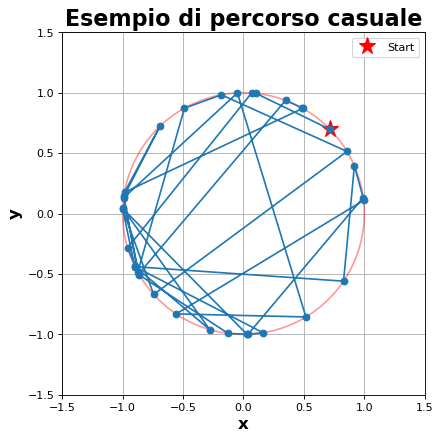

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

x,y = np.loadtxt("ex9/CIRCULAR/example_citycoord.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.plot(x[0],y[0], marker ="*", color = "r", markersize = 16, label = "Start", linestyle = "")
plt.plot(x, y, marker = "o", linestyle = "-")
plt.ylabel('y', fontsize = 15, fontweight = "bold")
plt.xlabel('x', fontsize = 15, fontweight = "bold")
plt.grid(True)
plt.title('Esempio di percorso casuale', fontsize = 20, fontweight = "bold")
plt.legend()

x = np.linspace(-1.0, 1.0, 100)
y = np.linspace(-1.0, 1.0, 100)
X, Y = np.meshgrid(x,y)
F = X**2 + Y**2 - 1
plt.contour(X,Y,F,[0], colors = "r", alpha = 0.4)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

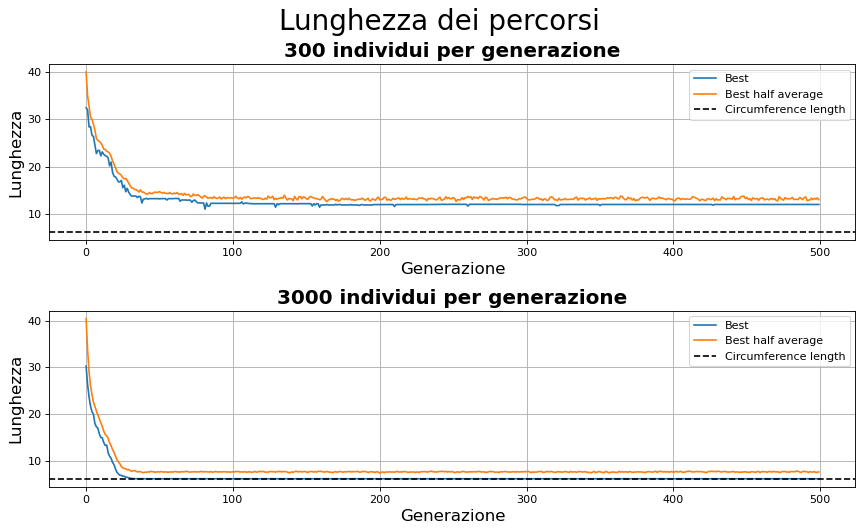

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(13, 7), dpi=80)
plt.suptitle("Lunghezza dei percorsi\n", fontsize = 25)

indivs =["300", "3000"]

for i in range(0,2):
    # using indivs[i] individuals per generation
    plt.subplot(2,1,i+1)
    gen,best = np.loadtxt("ex9/CIRCULAR/"+indivs[i]+"/bestLen/BL.out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(gen, best, marker = "", label = "Best") 
    bestave = np.loadtxt("ex9/CIRCULAR/"+indivs[i]+"/bestLen/BLAv.out", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(gen, bestave, marker = "", label = "Best half average") 
    plt.ylabel('Lunghezza', fontsize =15)
    plt.xlabel('Generazione', fontsize =15)
    plt.grid(True)
    plt.axhline(y=2*np.pi, color = 'k', linestyle = '--', label = "Circumference length")
    plt.title(indivs[i]+' individui per generazione', fontsize = 18, fontweight = "bold")
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

Ecco un'animazione dei migliori cammini per ogni generazione, avendo usato 300 e 3000 individui per generazione.


<img src="../img/movieC300.gif" width="500" height="500" /> <img src="../img/movieC3000.gif" width="500" height="500" />


### Osservazioni

Si vede che utilizzando una popolazione ridotta, la ricerca del minimo è meno ergodica: in questo caso ad esempio si blocca su un cammino "andata-ritorno" di lunghezza quasi doppia rispetto all'optimum.

## <span id="ex-9.2">  Esercizio 9.2 - Disposizione in un quadrato </span>[^](#toc)

Adesso applico il codice all'ottimizzazione di un percorso tra $34$ città piazzate casualmente all'interno di un quadrato. Al contrario di prima in linea di principio **non potrò mai sapere se ho trovato il percorso migliore** (a meno di provare tutte le $2.95\times 10^{38}$ permutazioni...).


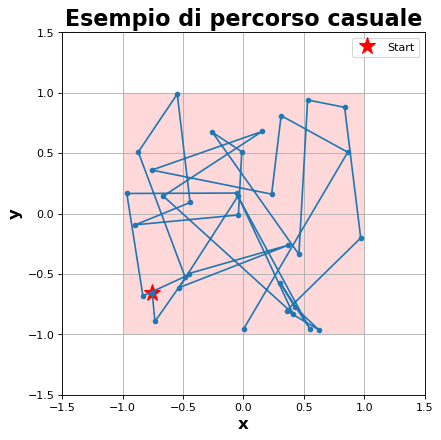

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=80)

x,y = np.loadtxt("ex9/SQUARE/example_citycoord.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.plot(x[0],y[0], marker ="*", color = "r", markersize = 16, label = "Start", linestyle = "")
plt.plot(x, y, marker = "o", markersize = 4, linestyle = "-")
plt.ylabel('y', fontsize = 15, fontweight = "bold")
plt.xlabel('x', fontsize = 15, fontweight = "bold")
plt.grid(True)
plt.title('Esempio di percorso casuale', fontsize = 20, fontweight = "bold")
plt.legend()

rectangle = plt.Rectangle((-1,-1), 2, 2, fc='r', alpha = 0.15)
plt.gca().add_patch(rectangle)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

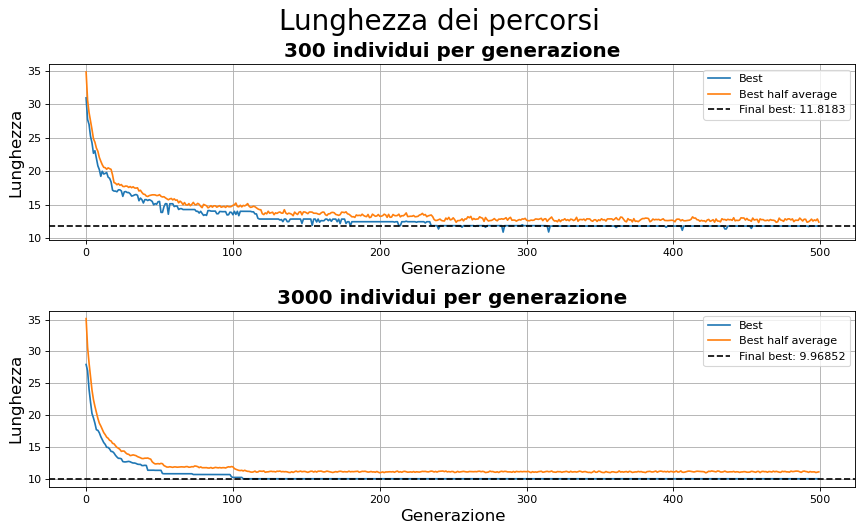

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

figure(figsize=(13, 7), dpi=80)
plt.suptitle("Lunghezza dei percorsi\n", fontsize = 25)

indivs =["300","3000"]

for i in range(0,2):
    # using indivs[i] individuals per generation
    plt.subplot(2,1,i+1)
    gen,best = np.loadtxt("ex9/SQUARE/"+indivs[i]+"/bestLen/BL.out", usecols=(0,1), delimiter=' ', unpack='true')
    plt.plot(gen, best, marker = "", label = "Best") 
    bestave = np.loadtxt("ex9/SQUARE/"+indivs[i]+"/bestLen/BLAv.out", usecols=(1), delimiter=' ', unpack='true')
    plt.plot(gen, bestave, marker = "", label = "Best half average") 
    plt.ylabel('Lunghezza', fontsize =15)
    plt.xlabel('Generazione', fontsize =15)
    plt.grid(True)
    plt.title(indivs[i]+' individui per generazione', fontsize = 18, fontweight = "bold")
    plt.axhline(y=best[499], color = "k", linestyle = "--", label = "Final best: "+str(best[499]))
    plt.legend()

plt.subplots_adjust(hspace=0.4)
plt.show()

Ecco un'animazione dei migliori cammini per ogni generazione, avendo usato 3000 individui per generazione.

<img src="../img/movieQ.gif" width="500" height="500" />

### Osservazioni

La curva *best half average* dà un'idea di quanto la popolazione continui a mutare e rimescolarsi anche una volta che il miglior individuo ha raggiunto la *migliore soluzione*: più è seghettata e distante dal best, più la ricerca è ergodica. Ritengo soddisfacente la soluzione trovata in questa esercitazione, mentre conto di approfondire la questione della calibrazione dei parametri nella prossima esercitazione, dove il compito è più sfidante.

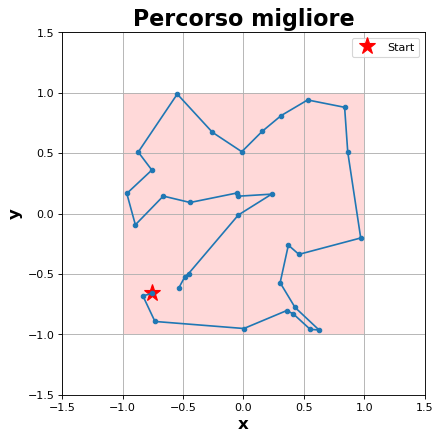

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure


figure(figsize=(8, 6), dpi=80)

x,y = np.loadtxt("ex9/SQUARE/best_citycoord.out", usecols=(0,1), delimiter=' ', unpack='true')
plt.plot(x[0],y[0], marker ="*", color = "r", markersize = 16, label = "Start", linestyle = "")
plt.plot(x, y, marker = "o", markersize = 4, linestyle = "-")
plt.ylabel('y', fontsize = 15, fontweight = "bold")
plt.xlabel('x', fontsize = 15, fontweight = "bold")
plt.grid(True)
plt.title('Percorso migliore', fontsize = 20, fontweight = "bold")
plt.legend()

rectangle = plt.Rectangle((-1,-1), 2, 2, fc='r', alpha = 0.15)
plt.gca().add_patch(rectangle)

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()